In [1]:
from PIL import Image
from PIL import ImageOps
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

root = Path(".") / "data"

In [2]:
class dataset:
    def __init__(self, directory):
        self.directory = directory
        self.name = str(directory)[-3:]
        self.num_images = len([file for file in os.listdir(directory) if ".tif" in file])
        self.resolution = Image.open(self.directory / os.listdir(self.directory)[0]).convert('RGB').size
        self.filepaths = [directory / file for file in os.listdir(directory) if ".tif" in file]
        self.size = len(self.filepaths)

class integrated_dataset:
    def __init__(self, root):
        self.dsets = [dataset(root / directory) for directory in os.listdir(root)]
        self.filepaths = []
        for dset in self.dsets:
            self.filepaths += dset.filepaths
    def im(self, filepath):
        # process the image
        # remove DC and tilt
        array = np.array(ImageOps.autocontrast(Image.open(filepath).convert('L').resize((256,256))))
        array = array - plane_fit(array)
        array = array - np.min(array)
        array = array / np.max(array)
        return array
    def raw_image(self, filepath):
        return np.array(Image.open(filepath).convert('L').resize((256,256)))
#     def sample(self, coord):
#         d, t, x, y = coord
#         x = x*16 + 8# range(4, 256, 8) 
#         y = y*16 + 8
#         return ImageOps.autocontrast(Image.open(self.dsets[d].filepaths[t]).convert('L').resize((256,256))).crop(box=(y-8, x-8, y+8, x+8))

def plane_fit(surface):
    f = lambda xy, a, b, c, d: ((a*xy[0] + b*xy[1] + d)/c).ravel()
    x = np.linspace(0, 255, 256)
    X, Y = np.meshgrid(x, x)
    (a, b, c, d), _ = curve_fit(f, (X,Y), surface.ravel())
    return (a*X+b*Y+d)/c

def thresh(surface, thresh=.5):
    result = np.zeros_like(surface)
    for row in range(np.shape(surface)[0]):
        for col in range(np.shape(surface)[1]):
            if surface[row][col] > thresh:
                result[row, col] = surface[row][col]
    return result

def blur(img):
    gauss = np.array([
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
        ])*1/16

    rows, cols = np.shape(img)
    test_img = np.zeros((rows+2, cols+2))
    test_img[1:rows+1, 1:cols+1] = img

    results = np.zeros((rows, cols))
    for row in range(0,rows):
        for col in range(0,cols):
            img_slice = test_img[row:3+row, col:3+col]
            results[row, col] = np.sum(img_slice*gauss)
    results = results - np.min(results)
    results = results / np.max(results)
    return results

In [3]:
# coordinate scheme: (d, t, x, y)
test = integrated_dataset(root)
# test.sample((0,0,0,5))

1.0 0.0008082522717126161 0.0


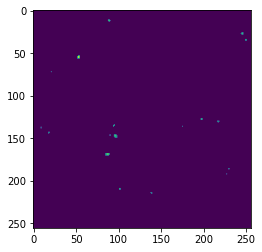

In [4]:
img = test.im(test.filepaths[0])
img = thresh(blur(img))
print(np.max(img), np.mean(img), np.min(img))
plt.imshow(img)

In [29]:
data = dataset(root / "data" / "002")
test = data.sample_vector()
test

(<PIL.Image.Image image mode=L size=256x256 at 0x1B017C0D910>,
 [<PIL.Image.Image image mode=L size=256x256 at 0x1B02B2EA340>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B012198D60>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B46F340>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B023036130>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF3D0>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF3A0>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AFF10>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AFF70>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF340>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF1C0>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF370>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AFF40>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF2E0>,
  <PIL.Image.Image image mode=L size=256x256 at 0x1B02B6AF070>,
  <PIL.Image.Image image mode=L size=256x

In [8]:
output = Path(".") / "output" / "002" / "indices.txt"
output2 = Path(".") / "output" / "002" / "indices_blur.txt"

test = blur(np.loadtxt(output, dtype=int))

%matplotlib qt
plt.imshow(test)

np.savetxt(output2, test, fmt='%f')

In [10]:
test = np.loadtxt(output2)

plt.imshow(test)